In [38]:
import re
import os, glob
import pandas as pd
import numpy as np
import scipy.stats as st
import pingouin as pg
import matplotlib.pyplot as plt

import seaborn as sns
import psignifit as ps


In [69]:
plt.rcParams.update({'font.size': 16})
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [70]:
data_path = 'selected/'

In [71]:
summary_a20 = pd.read_csv(os.path.join(data_path, "summary_a20.csv"))
summary_a45 = pd.read_csv(os.path.join(data_path, "summary_a45.csv"))
data_files  = glob.glob(os.path.join(data_path, 'a*'))

In [72]:
summary_a20.head()

,Unnamed: 0,time_taken,finished,stcoh1,stcoh2,acc_part2,handness,browser,resolution,age,birth,sex,residence,employment,language,nationality,student
0,0,44.815283,yes,0.132028,0.263955,83.796,right,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"1366,728",18.0,Spain,Female,United Kingdom,Unemployed (and job seeking),NaN,Spain,Yes
1,1,33.313283,yes,0.037313,0.081208,79.142,right,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4...,"1280,709",26.0,Lithuania,Male,Spain,Full-Time,Lithuanian,Lithuania,No
2,2,39.373500,yes,0.046708,0.129425,80.242,right,Mozilla/5.0 (X11; CrOS x86_64 13099.110.0) App...,"1366,720",27.0,Denmark,Male,Denmark,Full-Time,Danish,Denmark,No
3,3,31.026067,yes,0.085471,0.128092,80.196,right,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"1920,1040",18.0,Poland,Male,Poland,Part-Time,Polish,Poland,Yes
4,4,53.065417,yes,0.042722,0.076805,70.884,right,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:80...,"1252,667",38.0,Poland,Male,Poland,Full-Time,Polish,Poland,No


In [73]:
def extract_name_pattern(file_path):
    'from file path it returns info about an angle and subject id'
    file_name = file_path.split('/')[-1]
    rx = re.compile('a([0-9][0-9])_([0-9]+)\.')
    angle, subj_id = rx.findall(file_name)[0]
    return (int(angle), int(subj_id))

def extract_data_from_part2(dfp2, column_name, condition_tuple):
    '''
    IN:
      *dfp2* data frame from Part 2 of 2d RDK
      column_name
      *condition_tuple* is coherencies you want to extract
    OUT:
      vector with extracted data
    '''
    assert 'cohfix' in dfp2.columns, 'dfp2 lacks cohfix column'
    return dfp2[dfp2.cohfix.map(lambda x: list(x) == sorted(condition_tuple))][column_name].to_numpy()*1.

def compute_mean_sterr_from_vector(vect):
    'returns tuple with mean and sterr from *vect*'
    return np.mean(vect), np.std(vect)/np.sqrt(len(vect))

def get_avg_conditions_part2(dfp2, delta, stair_coh1, stair_coh2, column = 'correct'):
    'Extracts average summaries from all coditions from dfp2 matrix'
    v_ = extract_data_from_part2(dfp2, column, [delta, stair_coh1])
    cong_m, cong_s = compute_mean_sterr_from_vector(v_)
    v_ = extract_data_from_part2(dfp2, column, [0, stair_coh2])
    cong_true_m, cong_true_s = compute_mean_sterr_from_vector(v_)
    v_ = extract_data_from_part2(dfp2, column, [delta, stair_coh2])
    incong_m, incong_s = compute_mean_sterr_from_vector(v_)
    v_ = extract_data_from_part2(dfp2, column, [0, stair_coh1])
    incong_true_m, incong_true_s = compute_mean_sterr_from_vector(v_)
    return {'cong_m':cong_m, 'cong_s':cong_s, 'cong_true_m':cong_true_m, 'cong_true_s': cong_true_s,\
            'incong_m':incong_m, 'incong_s':incong_s, 'incong_true_m':incong_true_m, 'incong_true_s':incong_true_s}

def load_trial_data_part2(dfp2, delta, stair_coh1, stair_coh2):
    '''
    Loads single-trial data from part 2
    '''
    condition_tuple = [delta, stair_coh1]
    dfp2.loc[dfp2.cohfix.map(lambda x: list(x) == sorted(condition_tuple)), "axes"] = 2
    dfp2.loc[dfp2.cohfix.map(lambda x: list(x) == sorted(condition_tuple)), "cogr"] = 1
    dfp2.loc[dfp2.cohfix.map(lambda x: list(x) == sorted(condition_tuple)), "condition"] = "C2"
    condition_tuple = [0, stair_coh2]
    dfp2.loc[dfp2.cohfix.map(lambda x: list(x) == sorted(condition_tuple)), "axes"] = 1
    dfp2.loc[dfp2.cohfix.map(lambda x: list(x) == sorted(condition_tuple)), "cogr"] = 1
    dfp2.loc[dfp2.cohfix.map(lambda x: list(x) == sorted(condition_tuple)), "condition"] = "C1"
    condition_tuple = [delta, stair_coh2]
    dfp2.loc[dfp2.cohfix.map(lambda x: list(x) == sorted(condition_tuple)), "axes"] = 2
    dfp2.loc[dfp2.cohfix.map(lambda x: list(x) == sorted(condition_tuple)), "cogr"] = 0
    dfp2.loc[dfp2.cohfix.map(lambda x: list(x) == sorted(condition_tuple)), "condition"] = "I2"
    condition_tuple = [0, stair_coh1]
    dfp2.loc[dfp2.cohfix.map(lambda x: list(x) == sorted(condition_tuple)), "axes"] = 1
    dfp2.loc[dfp2.cohfix.map(lambda x: list(x) == sorted(condition_tuple)), "cogr"] = 0
    dfp2.loc[dfp2.cohfix.map(lambda x: list(x) == sorted(condition_tuple)), "condition"] = "I1"
    dfp2 = dfp2[['rt', 'correct', 'axes', 'cogr', 'condition']]
    return dfp2.dropna()

In [74]:
def read_part1(df):
    '''
    Reads data from Part 1 of 2d RDK experiment
    IN:
      *df* - pd.DataFrame
        dataframe with data read
    OUT:
      dictionary with all the details
    '''
    stair_coh1 = float(df.stair_coh1[df.stair_coh1>0])
    stair_coh2 = float(df.stair_coh2[df.stair_coh2>0])
    delta_st   = np.abs(stair_coh1-stair_coh2)
    stair_coh1 = np.round(stair_coh1, 5)
    stair_coh2 = np.round(stair_coh2, 5)
    delta_st   = np.round(delta_st, 5)
    part_1_start = np.where(df['stimulus'].str.contains('You are ready to start <b>PART 1</b>').to_numpy()==True)[0][0]
    part_1_end = np.where(df['stimulus'].str.contains('You successfully finished PART 1').to_numpy()==True)[0][0]
    dfp1 = df.iloc[part_1_start:part_1_end,:]
    dfp1 = dfp1[dfp1.trial_type == 'RDK']
    rx = re.compile("<font color='grey'>(.*)</font>")
    dfp1['which_stair'] = df.iloc[dfp1.index-2].stimulus.map(lambda x: rx.findall(x)[0]).to_numpy()
    stairs_c1 = [(float(c.split(',')[0]), float(c.split(',')[1])) for c in dfp1[dfp1['which_stair']=='coh1'].coherence.to_numpy()]
    stairs_c1 = [c1 if c2 == 0 else c2 for c1,c2 in stairs_c1]
    stairs_c2 = [(float(c.split(',')[0]), float(c.split(',')[1])) for c in dfp1[dfp1['which_stair']=='coh2'].coherence.to_numpy()]
    stairs_c2 = [c1 if c2 == 0 else c2 for c1,c2 in stairs_c2]
    return {'stair_coh1':stair_coh1, 'stair_coh2':stair_coh2, 'delta':delta_st, 'stairs_c1': stairs_c1, 'stairs_c2': stairs_c2}

def read_part2(df, delta, stair_coh1, stair_coh2):
    '''
    Reads data from Part 1 of 2d RDK experiment
    IN:
      *df* - pd.DataFrame
        dataframe with data read
    OUT:
      dictionary with all the details
    '''
    part_2_start = np.where(df['stimulus'].str.contains('You are ready to start PART 2').to_numpy()==True)[0][0]
    part_2_end = np.where(df['stimulus'].str.contains('You finished the last block!').to_numpy()==True)[0][0]
    dfp2 = df.iloc[part_2_start:part_2_end,:]
    dfp2 = dfp2[dfp2.trial_type == 'RDK']
    dfp2['cohfix'] = dfp2.coherence.str.split(',').map(lambda x: tuple(np.round(sorted((float(x[0]), float(x[1]))),5)))

    dfp2 = dfp2[['rt', 'correct', 'time_elapsed', 'cohfix']]

    corrects = get_avg_conditions_part2(dfp2, delta, stair_coh1, stair_coh2, 'correct')
    rts = get_avg_conditions_part2(dfp2, delta, stair_coh1, stair_coh2, 'rt')
    single_trial = load_trial_data_part2(dfp2, delta, stair_coh1, stair_coh2)
    return {'corrects': corrects, 'rts':rts, 'trials':single_trial}

def read_data_from_2drdk(path):
    '''
    Reads data from 2d RDK experiment and parses the most important information.
    IN:
      *path* - str
        path to the file from
    OUT:
      dictionary with all the details
    '''
    df = pd.read_csv(path)
    # decode the file name
    angle, subj_id = extract_name_pattern(path)
    subj_id = '{}_{}'.format(angle, subj_id)
    # reading data from part 1
    part1 = read_part1(df)
    # reading data from part 2
    part2 = read_part2(df, part1['delta'], part1['stair_coh1'], part1['stair_coh2'])
    return {'part1': part1, 'part2': part2, 'angle': angle, 'subj_id': subj_id}

In [75]:
subj_20 = []
subj_45 = []
for fp in data_files:
    user_data = read_data_from_2drdk(fp)
    if user_data['angle'] == 20:
        subj_20.append(user_data)
    elif user_data['angle'] == 45:
        subj_45.append(user_data)
    else:
        raise ValueError('angle not recognised: {}'.format(user_data['angle']))

## Group analysis Part 1

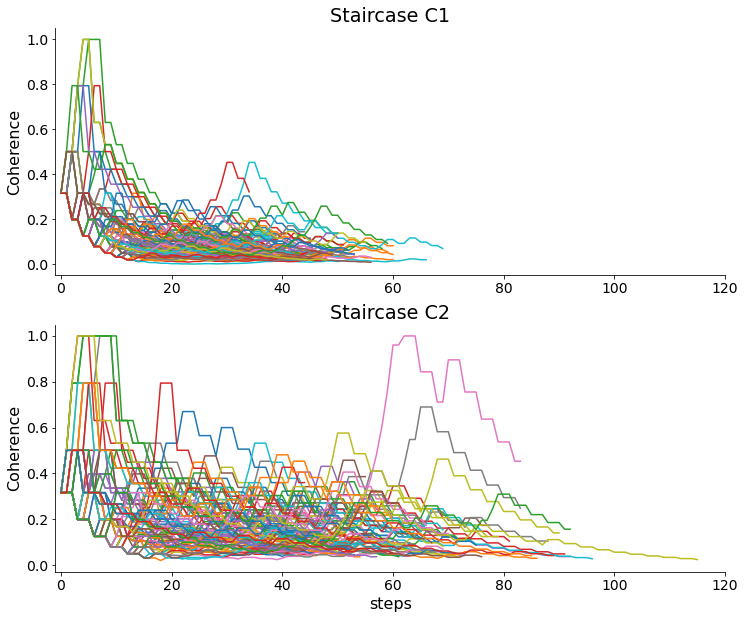

In [76]:
plt.figure(figsize=(12,10))
plt.subplot(211)
for i in range(len(subj_20)):
    plt.plot(range(len(subj_20[i]['part1']['stairs_c1'])), subj_20[i]['part1']['stairs_c1'])
for i in range(len(subj_45)):
    plt.plot(range(len(subj_45[i]['part1']['stairs_c1'])), subj_45[i]['part1']['stairs_c1'])
plt.title('Staircase C1')
plt.ylabel('Coherence')
plt.xlim([-1, 120])
plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.subplot(212)
for i in range(len(subj_20)):
    plt.plot(range(len(subj_20[i]['part1']['stairs_c2'])), subj_20[i]['part1']['stairs_c2'])
for i in range(len(subj_45)):
    plt.plot(range(len(subj_45[i]['part1']['stairs_c2'])), subj_45[i]['part1']['stairs_c2'])
plt.title('Staircase C2')
plt.xlabel('steps')
plt.ylabel('Coherence')
plt.xlim([-1, 120])
plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.savefig('staircase.png')
plt.show()

In [77]:
stairs_coh1_20 = []
stairs_coh2_20 = []
for i in range(len(subj_20)):
    stairs_coh1_20.append(subj_20[i]['part1']['stair_coh1'])
    stairs_coh2_20.append(subj_20[i]['part1']['stair_coh2'])
stairs_coh1_45 = []
stairs_coh2_45 = []
for i in range(len(subj_45)):
    stairs_coh1_45.append(subj_45[i]['part1']['stair_coh1'])
    stairs_coh2_45.append(subj_45[i]['part1']['stair_coh2'])

In [78]:
avg_coh1_20, ste_coh1_20 = compute_mean_sterr_from_vector(stairs_coh1_20)
avg_coh2_20, ste_coh2_20 = compute_mean_sterr_from_vector(stairs_coh2_20)
avg_coh1_45, ste_coh1_45 = compute_mean_sterr_from_vector(stairs_coh1_45)
avg_coh2_45, ste_coh2_45 = compute_mean_sterr_from_vector(stairs_coh2_45)

In [79]:
_ , p_cohs = st.mannwhitneyu(stairs_coh1_20 + stairs_coh1_45, stairs_coh2_20 + stairs_coh2_45)
p_cohs

5.3977284108808915e-15

In [80]:
_ , p_coh1 = st.mannwhitneyu(stairs_coh1_20, stairs_coh1_45)
_ , p_coh2 = st.mannwhitneyu(stairs_coh2_20, stairs_coh2_45)

In [81]:
def plot_barplot_two_means(avg1, ste1, avg2, ste2, p_val = None,
                           name1 = 'A', name2 = 'B',
                           y_lim = None, y_label = None, x_label = None, bar_col = 'grey',
                           shift = 0.2, alpha = 0.05):
    '''
    Plots two barplot from two means and standard errors.
    IN:
      *avg1*, *avg2* - float
        average 1 and average 2
      *ste1*, *ste2* - float
        standard errors 1 & 2
      *p_val* - float
        p value from statistical test comapring two groups
      *name1* = 'A', *name2* = 'B' - str, int
        names to display on x axis
      *y_lim* - list of 2 elements, tuple
        limits of y axis
      *y_label*, *x_label* - str
        y,x label
      *bar_col* = 'grey' - str
        barplto colour
      *shift* - float
        shift between bars
      *alpha* - float
        significance level (only if *p_val* provided)
    OUT:
      plot from matplotlib
    '''
    if y_lim:
        min_lim = y_lim[0]
        max_lim = y_lim[-1]
    else:
        min_lim = 0
        max_lim = np.max([avg1, avg2])
    plt.bar([0, 1], [avg1, avg2], yerr = [ste1, ste2], color = bar_col)
    plt.xticks([0, 1], [name1, name2])
    if y_lim:
        plt.ylim(y_lim)
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)
    plt.text(0-shift, min_lim+0.5*(max_lim-min_lim), '{:.2f} +- {:.2f}'.format(avg1, ste1))
    plt.text(1-shift, min_lim+0.5*(max_lim-min_lim), '{:.2f} +- {:.2f}'.format(avg2, ste2))
    if p_val:
        plt.text(0.5-shift, 0.9*max_lim, '{} ({})'.format('*' if p_val < alpha else 'ns',
                                            "p={:.2f}".format(p_val) if p_val >= 0.01 else "p<0.01"))


def plot_paired_value_lines(group1_vals, group2_vals, p_val = None,
                           name1 = 'A', name2 = 'B',
                           y_lim = None, y_label = None, x_label = None,
                           shift = 0.2, alpha = 0.05):
    '''
    Plots paired values by dots connected with lines.
    IN:
      *group1_vals*, *group2_vals* - list
        values from the first and second groups (need to have the same length)
      *p_val* - float
        p value from statistical test comapring two groups
      *name1* = 'A', *name2* = 'B' - str, int
        names to display on x axis
      *y_lim* - list of 2 elements, tuple
        limits of y axis
      *y_label*, *x_label* - str
        y,x label
      *shift* - float
        shift between bars
      *alpha* - float
        significance level (only if *p_val* provided)
    OUT:
      plot from matplotlib
    '''
    assert len(group1_vals) == len(group2_vals), "length of groups is not the same"
    if y_lim:
        max_lim = y_lim[-1]*0.9
    else:
        max_lim = np.max([np.max(group1_vals), np.max(group2_vals)])
    for i in range(len(group1_vals)):
        plt.plot([0, 1], [group1_vals[i], group2_vals[i]], 'o-')
    plt.xticks([0, 1], [name1, name2])
    plt.xlim([-0.5, 1.5])
    if y_lim:
        plt.ylim(y_lim)
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)
    if p_val:
        plt.text(0.5-shift, 0.9*max_lim, '{} ({})'.format('*' if p_val < alpha else 'ns',
                                                                "p={:.2f}".format(p_val) if p_val >= 0.01 else "p<0.01"),
                bbox=dict(boxstyle="round", fc='#ced5df', alpha=0.8))


In [102]:
def plot_two_violin_plots(values1, values2, p_val = None,
                          name1 = 'A', name2 = 'B',
                          y_lim = None, y_label = None, x_label = None,
                          col = 'grey', alpha = 0.05, lines = 0):
    '''
    Plots two violin plots from two numpy arrays.
    IN:
      *values1*, *values2* - float
        values 1 and values 2
      *p_val* - float
        p value from statistical test comapring two groups
      *name1* = 'A', *name2* = 'B' - str, int
        names to display on x axis
      *y_lim* - list of 2 elements, tuple
        limits of y axis
      *y_label*, *x_label* - str
        y,x label
      *col* = 'grey' - str
        barplto colour
      *alpha* - float
        significance level (only if *p_val* provided)
      *lines* - bool
        flag to plot lines from underlying points
    OUT:
      plot from matplotlib
    '''
    if y_lim:
        min_lim = y_lim[0]
        max_lim = y_lim[-1]
    else:
        min_lim = 0
        max_lim = np.max([np.max(values1), np.max(values2)])
    dat = pd.DataFrame({'values' : np.concatenate((np.array(values1), np.array(values2))),
                 'x' : [name1]*len(values1) + [name2]*len(values2)})
    if lines == 1:
        for i in range(len(values1)):
            plt.plot([0, 1], [values1[i], values2[i]], 'o-', color = 'k', alpha = 0.4)
    elif lines == 2:
        sns.stripplot(x = 'x', y = 'values', data = dat, jitter=True, color = 'k', marker='o', alpha=0.4)
    sns.violinplot(x = 'x', y = 'values', data = dat, scale = 'count', color = col, cut = 0)
    if y_lim:
        plt.ylim(y_lim)
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)
    if p_val:
        plt.text(0.5, 0.95*max_lim, '{}'.format('*' if p_val < alpha else 'ns'))

def plot_two_boxplots(values1, values2, p_val = None,
                   name1 = 'A', name2 = 'B',
                   y_lim = None, y_label = None, x_label = None, col = 'grey', alpha = 0.05):
    '''
    Plots two box-plots from two numpy arrays.
    IN:
      *values1*, *values2* - float
        values 1 and values 2
      *p_val* - float
        p value from statistical test comapring two groups
      *name1* = 'A', *name2* = 'B' - str, int
        names to display on x axis
      *y_lim* - list of 2 elements, tuple
        limits of y axis
      *y_label*, *x_label* - str
        y,x label
      *col* = 'grey' - str
        barplto colour
      *alpha* - float
        significance level (only if *p_val* provided)
    OUT:
      plot from matplotlib
    '''
    if y_lim:
        min_lim = y_lim[0]
        max_lim = y_lim[-1]
    else:
        min_lim = 0
        max_lim = np.max([np.max(values1), np.max(values2)])
    dat = pd.DataFrame({'values' : np.concatenate((np.array(values1), np.array(values2))),
                 'x' : [name1]*len(values1) + [name2]*len(values2)})
    sns.boxplot(x = 'x', y = 'values', data = dat, color = col, width = 0.65)
    if y_lim:
        plt.ylim(y_lim)
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)
    if p_val:
        plt.axhline(y=0.91*max_lim, xmin=.25, xmax=.75, color = 'k')
        plt.text(0.48, 0.93*max_lim, '{}'.format('*' if p_val < alpha else 'ns'))
        
def plot_paired_barplots(group1_vals, group2_vals, p_val = None,
                           name1 = 'A', name2 = 'B',
                           y_lim = None, y_label = None, x_label = None,
                           bar_col = 'red', shift = 0.2, alpha = 0.05, p_pos = None):
    '''
    Plots two barplots from two means and standard errors.
    IN:
      *group1_vals*, *group2_vals* - list
        values from the first and second groups (need to have the same length)
      *p_val* - float
        p value from statistical test comapring two groups
      *name1* = 'A', *name2* = 'B' - str, int
        names to display on x axis
      *y_lim* - list of 2 elements, tuple
        limits of y axis
      *y_label*, *x_label* - str
        y,x label
      *shift* - float
        shift between bars
      *bar_col* - str
        colour of the bars
      *alpha* - float
        significance level (only if *p_val* provided)
      *p_pos* - float
        position of p value marker
    OUT:
      plot from matplotlib
    '''
    assert len(group1_vals) == len(group2_vals), "length of groups is not the same"
    if y_lim:
        max_lim = y_lim[-1]
    else:
        max_lim = np.max([np.max(group1_vals), np.max(group2_vals)])
    avg1 = np.mean(group1_vals)
    avg2 = np.mean(group2_vals)
    for i in range(len(group1_vals)):
        plt.plot([0, 1], [group1_vals[i], group2_vals[i]], 'o-', color = 'grey', alpha = 0.7)
    plt.bar([0, 1], [avg1, avg2], color = bar_col, alpha = 0.7, width = 0.65, zorder=9999)
    plt.xticks([0, 1], [name1, name2])
    plt.xlim([-0.5, 1.5])
    if y_lim:
        plt.ylim(y_lim)
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)
    if p_val:
        if p_pos is None:
            plt.axhline(y=0.91*max_lim, xmin=.25, xmax=.75, color = 'k')
            plt.text(0.48, 0.93*max_lim, '{}'.format('*' if p_val < alpha else 'ns'))
        else:
            plt.axhline(y=p_pos - 0.02, xmin=.25, xmax=.75, color = 'k')
            plt.text(0.48, p_pos, '{}'.format('*' if p_val < alpha else 'ns'))            

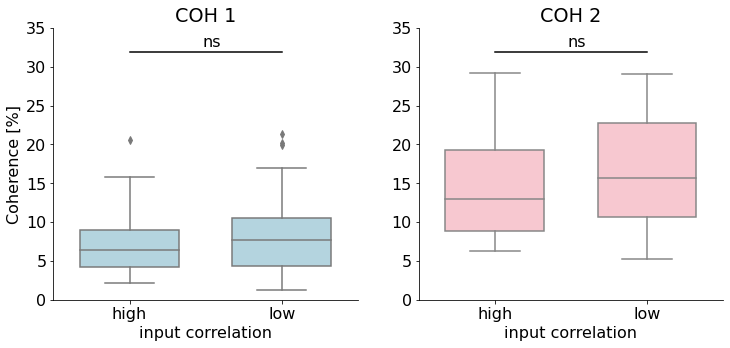

In [83]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plot_two_boxplots(100*np.array(stairs_coh1_20), 100*np.array(stairs_coh1_45), p_val = p_coh1, name1 = 'high', name2 = 'low', x_label = 'input correlation', col = 'lightblue', y_lim = [0,35])
plt.title('COH 1')
plt.ylabel('Coherence [%]')
plt.ylim([0,35])
plt.subplot(122)
plot_two_boxplots(100*np.array(stairs_coh2_20), 100*np.array(stairs_coh2_45), p_val = p_coh1, name1 = 'high', name2 = 'low', x_label = 'input correlation', col = 'pink', y_lim = [0,35])
plt.ylabel('')
plt.title('COH 2')
plt.savefig('compcohs_box.png')
plt.show()

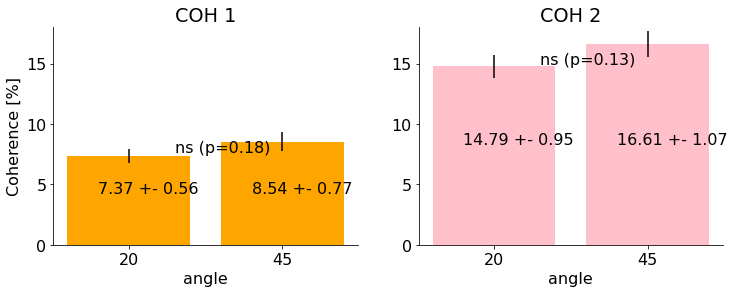

In [84]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plot_barplot_two_means(100*avg_coh1_20, 100*ste_coh1_20, 100*avg_coh1_45, 100*ste_coh1_45, p_val = p_coh1, name1 = 20, name2 = 45, x_label = 'angle', bar_col = 'orange')
plt.title('COH 1')
plt.ylabel('Coherence [%]')
plt.ylim([0,18])
plt.subplot(122)
plot_barplot_two_means(100*avg_coh2_20, 100*ste_coh2_20, 100*avg_coh2_45, 100*ste_coh2_45, p_val = p_coh2, name1 = 20, name2 = 45, x_label = 'angle', bar_col = 'pink')
plt.ylim([0,18])
plt.title('COH 2')
plt.savefig('compcohs.png')
plt.show()

## Group analysis Part 2

### Accuracies

In [85]:
correct_congr_20, correct_incon_20 = [], []
correct_congr_tr_20, correct_incon_tr_20 = [], []
for i in range(len(subj_20)):
    correct_congr_20.append(subj_20[i]['part2']['corrects']['cong_m'])
    correct_incon_20.append(subj_20[i]['part2']['corrects']['incong_m'])
    correct_congr_tr_20.append(subj_20[i]['part2']['corrects']['cong_true_m'])
    correct_incon_tr_20.append(subj_20[i]['part2']['corrects']['incong_true_m'])
correct_congr_45, correct_incon_45 = [], []
correct_congr_tr_45, correct_incon_tr_45 = [], []
for i in range(len(subj_45)):
    correct_congr_45.append(subj_45[i]['part2']['corrects']['cong_m'])
    correct_incon_45.append(subj_45[i]['part2']['corrects']['incong_m'])
    correct_congr_tr_45.append(subj_45[i]['part2']['corrects']['cong_true_m'])
    correct_incon_tr_45.append(subj_45[i]['part2']['corrects']['incong_true_m'])

In [86]:
t_st_con_20, p_con_20 = st.ttest_rel(correct_congr_20, correct_congr_tr_20)
t_st_inc_20, p_inc_20 = st.ttest_rel(correct_incon_20, correct_incon_tr_20)
t_st_con_45, p_con_45 = st.ttest_rel(correct_congr_45, correct_congr_tr_45)
t_st_inc_45, p_inc_45 = st.ttest_rel(correct_incon_45, correct_incon_tr_45)

In [87]:
avg_cong_20, ste_cong_20 = compute_mean_sterr_from_vector(correct_congr_20)
avg_contr_20, ste_contr_20 = compute_mean_sterr_from_vector(correct_congr_tr_20)

avg_inc_20, ste_inc_20 = compute_mean_sterr_from_vector(correct_incon_20)
avg_inctr_20, ste_inctr_20 = compute_mean_sterr_from_vector(correct_incon_tr_20)

avg_cong_45, ste_cong_45 = compute_mean_sterr_from_vector(correct_congr_45)
avg_contr_45, ste_contr_45 = compute_mean_sterr_from_vector(correct_congr_tr_45)

avg_inc_45, ste_inc_45 = compute_mean_sterr_from_vector(correct_incon_45)
avg_inctr_45, ste_inctr_45 = compute_mean_sterr_from_vector(correct_incon_tr_45)

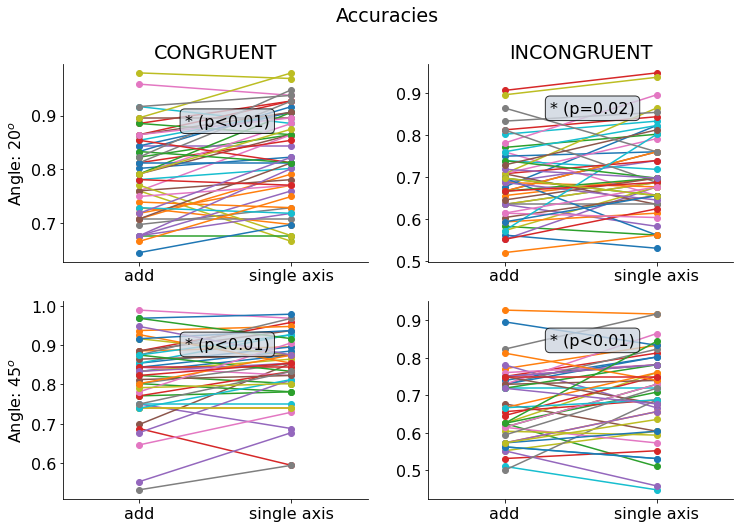

In [88]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plot_paired_value_lines(correct_congr_20, correct_congr_tr_20, p_val = p_con_20, name1 = 'add', name2 = 'single axis', y_label = 'Angle: 20$^o$')
#plot_barplot_two_means(avg_cong_20, ste_cong_20, avg_contr_20, ste_contr_20, p_val = p_con_20, name1 = 'add', name2 = 'single axis', y_label = 'Angle: 20$^o$', bar_col = '#ffda4f')
plt.title('CONGRUENT')
plt.subplot(222)
plot_paired_value_lines(correct_incon_20, correct_incon_tr_20, p_val = p_inc_20, name1 = 'add', name2 = 'single axis')
#plot_barplot_two_means(avg_inc_20, ste_inc_20, avg_inctr_20, ste_inctr_20, p_val = p_inc_20, name1 = 'add', name2 = 'single axis', bar_col = '#dbdcff')
plt.title('INCONGRUENT')
plt.subplot(223)
plot_paired_value_lines(correct_congr_45, correct_congr_tr_45, p_val = p_con_45, name1 = 'add', name2 = 'single axis', y_label = 'Angle: 45$^o$')
#plot_barplot_two_means(avg_cong_45, ste_cong_45, avg_contr_45, ste_contr_45, p_val = p_con_45, name1 = 'add', name2 = 'single axis', y_label = 'Angle: 45$^o$', bar_col = '#ffda4f')
plt.subplot(224)
plot_paired_value_lines(correct_incon_45, correct_incon_tr_45, p_val = p_inc_45, name1 = 'add', name2 = 'single axis')
#plot_barplot_two_means(avg_inc_45, ste_inc_45, avg_inctr_45, ste_inctr_45, p_val = p_inc_45, name1 = 'add', name2 = 'single axis', bar_col = '#dbdcff')
plt.suptitle('Accuracies')
plt.savefig('accuracies.png')
plt.show()

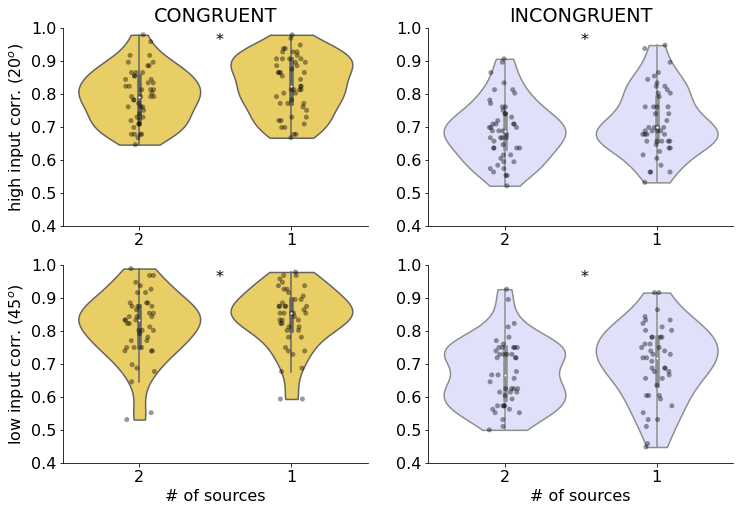

In [89]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plot_two_violin_plots(correct_congr_20, correct_congr_tr_20, p_val = p_con_20,
                      name1 = '2', name2 = '1', y_label = 'high input corr. (20$^o$)',
                      col = '#ffda4f', y_lim = [0.4, 1], lines = 2, x_label = ' ')
plt.title('CONGRUENT')
plt.subplot(222)
plot_two_violin_plots(correct_incon_20, correct_incon_tr_20, p_val = p_inc_20,
                      name1 = '2', name2 = '1', y_label = ' ',
                      col = '#dbdcff', y_lim = [0.4, 1], lines = 2, x_label = ' ')
plt.title('INCONGRUENT')
plt.subplot(223)
plot_two_violin_plots(correct_congr_45, correct_congr_tr_45, p_val = p_con_45,
                      name1 = '2', name2 = '1', y_label = 'low input corr. (45$^o$)',
                      col = '#ffda4f', y_lim = [0.4, 1], lines = 2, x_label = '# of sources')
plt.subplot(224)
plot_two_violin_plots(correct_incon_45, correct_incon_tr_45, p_val = p_inc_45,
                      name1 = '2', name2 = '1', y_label = ' ',
                      col = '#dbdcff', y_lim = [0.4, 1], lines = 2, x_label = '# of sources')
plt.savefig('accuracies_violin.png')
plt.show()

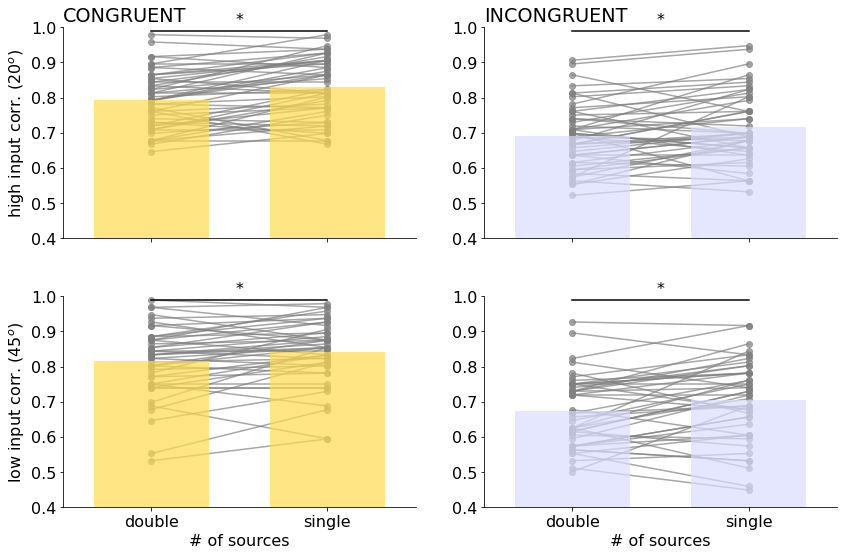

In [103]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plot_paired_barplots(correct_congr_20, correct_congr_tr_20, p_val = p_con_20,
                      name1 = '', name2 = '', y_label = 'high input corr. (20$^o$)',
                      bar_col = '#ffda4f', y_lim = [0.4, 1], x_label = ' ', p_pos=1.01)
plt.title('CONGRUENT', loc = 'left')
plt.subplot(222)
plot_paired_barplots(correct_incon_20, correct_incon_tr_20, p_val = p_inc_20,
                      name1 = '', name2 = '', y_label = ' ',
                      bar_col = '#dbdcff', y_lim = [0.4, 1], x_label = ' ', p_pos=1.01)
plt.title('INCONGRUENT', loc = 'left')
plt.subplot(223)
plot_paired_barplots(correct_congr_45, correct_congr_tr_45, p_val = p_con_45,
                      name1 = 'double', name2 = 'single', y_label = 'low input corr. (45$^o$)',
                      bar_col = '#ffda4f', y_lim = [0.4, 1], x_label = '# of sources', p_pos=1.01)
plt.subplot(224)
plot_paired_barplots(correct_incon_45, correct_incon_tr_45, p_val = p_inc_45,
                      name1 = 'double', name2 = 'single', y_label = ' ',
                      bar_col = '#dbdcff', y_lim = [0.4, 1], x_label = '# of sources', p_pos=1.01)
plt.tight_layout()
plt.savefig('accuracies_bars.png')
plt.show()

In [21]:
t_st_con, p_con = st.ttest_ind(correct_congr_20, correct_congr_45)
t_st_inc, p_inc = st.ttest_ind(correct_incon_20, correct_incon_45)
t_st_con_t, p_con_t = st.ttest_ind(correct_congr_tr_20, correct_congr_tr_45)
t_st_inc_t, p_inc_t = st.ttest_ind(correct_incon_tr_20, correct_incon_tr_45)

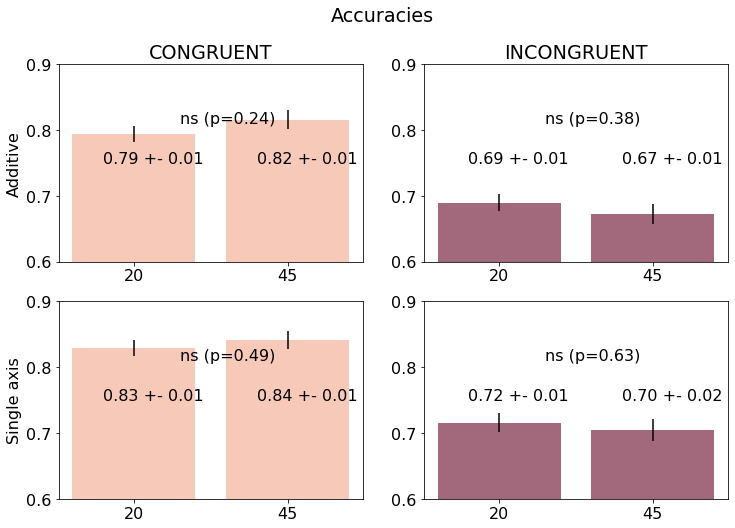

In [22]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plot_barplot_two_means(avg_cong_20, ste_cong_20, avg_cong_45, ste_cong_45, p_val = p_con, name1 = '20', name2 = '45', y_label = 'Additive', bar_col = '#f6c9b9', y_lim = (0.6, 0.9))
plt.title('CONGRUENT')
plt.subplot(222)
plot_barplot_two_means(avg_inc_20, ste_inc_20, avg_inc_45, ste_inc_45, p_val = p_inc, name1 = '20', name2 = '45', bar_col = '#a2697d', y_lim = (0.6, 0.9))
plt.title('INCONGRUENT')
plt.subplot(223)
plot_barplot_two_means(avg_contr_20, ste_contr_20, avg_contr_45, ste_contr_45, p_val = p_con_t, name1 = '20', name2 = '45', y_label = 'Single axis', bar_col = '#f6c9b9', y_lim = (0.6, 0.9))
plt.subplot(224)
plot_barplot_two_means(avg_inctr_20, ste_inctr_20, avg_inctr_45, ste_inctr_45, p_val = p_inc_t, name1 = '20', name2 = '45', bar_col = '#a2697d', y_lim = (0.6, 0.9))
plt.suptitle('Accuracies')
plt.savefig('accuracies_angles.png')
plt.show()

In [23]:
from statsmodels.stats.anova import AnovaRM

In [24]:
df_anova20 = pd.DataFrame(
    {'pid': np.tile(np.tile(np.arange(len(correct_congr_20)), 2), 2),
    'axis': np.concatenate((np.zeros(len(correct_congr_20)), np.ones(len(correct_congr_tr_20)), np.zeros(len(correct_incon_20)), np.ones(len(correct_incon_tr_20)))),
    'congr': np.concatenate((np.zeros(len(correct_congr_20)+len(correct_congr_tr_20)), np.ones(len(correct_incon_20)+len(correct_incon_tr_20)))),
    'correct': np.concatenate((correct_congr_20, correct_congr_tr_20, correct_incon_20, correct_incon_tr_20)) })

In [25]:
print('Angle: 20 (acc)')
print(AnovaRM(data = df_anova20, depvar='correct', subject='pid', within=['axis', 'congr']).fit())

Angle: 20 (acc)
                  Anova
           F Value  Num DF  Den DF Pr > F
-----------------------------------------
axis        31.5188 1.0000 48.0000 0.0000
congr      165.3793 1.0000 48.0000 0.0000
axis:congr   0.3904 1.0000 48.0000 0.5350



In [26]:
df_anova45 = pd.DataFrame(
    {'pid': np.tile(np.tile(np.arange(len(correct_congr_45)), 2), 2),
    'axis': np.concatenate((np.zeros(len(correct_congr_45)), np.ones(len(correct_congr_tr_45)), np.zeros(len(correct_incon_45)), np.ones(len(correct_incon_tr_45)))),
    'congr': np.concatenate((np.zeros(len(correct_congr_45)+len(correct_congr_tr_45)), np.ones(len(correct_incon_45)+len(correct_incon_tr_45)))),
    'correct': np.concatenate((correct_congr_45, correct_congr_tr_45, correct_incon_45, correct_incon_tr_45)) })
print('Angle: 45 (acc)')
print(AnovaRM(data = df_anova45, depvar='correct', subject='pid', within=['axis', 'congr']).fit())

Angle: 45 (acc)
                  Anova
           F Value  Num DF  Den DF Pr > F
-----------------------------------------
axis        18.2368 1.0000 44.0000 0.0001
congr      118.4301 1.0000 44.0000 0.0000
axis:congr   0.2089 1.0000 44.0000 0.6499



In [27]:
posthocs = pg.pairwise_ttests(data = df_anova20, dv='correct', subject='pid', within=['axis', 'congr'])
posthocs

,Contrast,axis,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,axis,-,0,1,True,True,-5.614156,48.0,two-sided,9.686118e-07,1.694e+04,-0.376222
1,congr,-,0,1,True,True,12.859989,48.0,two-sided,3.647875e-17,1.598e+14,1.288534
2,axis * congr,0,0,1,True,True,9.740308,48.0,two-sided,5.951275e-13,1.373e+10,1.198403
3,axis * congr,1,0,1,True,True,9.714229,48.0,two-sided,6.487224e-13,1.264e+10,1.210478


In [28]:
posthocs = pg.pairwise_ttests(data = df_anova45, dv='correct', subject='pid', within=['axis', 'congr'])
posthocs

,Contrast,axis,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,axis,-,0,1,True,True,-4.270462,44.0,two-sided,1.025076e-04,230.696,-0.327295
1,congr,-,0,1,True,True,10.882562,44.0,two-sided,4.615285e-14,1.601e+11,1.450078
2,axis * congr,0,0,1,True,True,9.503314,44.0,two-sided,3.139097e-12,2.779e+09,1.419542
3,axis * congr,1,0,1,True,True,9.230052,44.0,two-sided,7.448158e-12,1.214e+09,1.312376


In [29]:
df_anova45.pid = df_anova45.pid + max(df_anova20.pid)+1
df_anova_all = pd.concat((df_anova20, df_anova45))
df_anova_all['angle'] = [20]*df_anova20.shape[0] + [45]*df_anova45.shape[0]

In [30]:
jaspdf = {'pid': list(range(len(correct_congr_20) + len(correct_congr_45))),
 'cong_2':correct_congr_20 + correct_congr_45,
 'cong_1':correct_congr_tr_20 + correct_congr_tr_45,
 'inc_2':correct_incon_20 + correct_incon_45,
 'inc_1':correct_incon_tr_20 + correct_incon_tr_45,
 'angle':len(correct_congr_20)*[20]+len(correct_congr_45)*[45]}
jaspdf = pd.DataFrame(jaspdf)
jaspdf.to_csv("acc_jasp.csv")

### RTs

In [90]:
rt_congr_20, rt_incon_20 = [], []
rt_congr_tr_20, rt_incon_tr_20 = [], []
for i in range(len(subj_20)):
    rt_congr_20.append(subj_20[i]['part2']['rts']['cong_m'])
    rt_incon_20.append(subj_20[i]['part2']['rts']['incong_m'])
    rt_congr_tr_20.append(subj_20[i]['part2']['rts']['cong_true_m'])
    rt_incon_tr_20.append(subj_20[i]['part2']['rts']['incong_true_m'])
rt_congr_45, rt_incon_45 = [], []
rt_congr_tr_45, rt_incon_tr_45 = [], []
for i in range(len(subj_45)):
    rt_congr_45.append(subj_45[i]['part2']['rts']['cong_m'])
    rt_incon_45.append(subj_45[i]['part2']['rts']['incong_m'])
    rt_congr_tr_45.append(subj_20[i]['part2']['rts']['cong_true_m'])
    rt_incon_tr_45.append(subj_20[i]['part2']['rts']['incong_true_m'])

In [91]:
t_st_con_20, p_con_20 = st.ttest_rel(rt_congr_20, rt_congr_tr_20)
t_st_inc_20, p_inc_20 = st.ttest_rel(rt_incon_20, rt_incon_tr_20)
t_st_con_45, p_con_45 = st.ttest_rel(rt_congr_45, rt_congr_tr_45)
t_st_inc_45, p_inc_45 = st.ttest_rel(rt_incon_45, rt_incon_tr_45)

In [92]:
avg_cong_20, ste_cong_20 = compute_mean_sterr_from_vector(rt_congr_20)
avg_contr_20, ste_contr_20 = compute_mean_sterr_from_vector(rt_congr_tr_20)

avg_inc_20, ste_inc_20 = compute_mean_sterr_from_vector(rt_incon_20)
avg_inctr_20, ste_inctr_20 = compute_mean_sterr_from_vector(rt_incon_tr_20)

avg_cong_45, ste_cong_45 = compute_mean_sterr_from_vector(rt_congr_45)
avg_contr_45, ste_contr_45 = compute_mean_sterr_from_vector(rt_congr_tr_45)

avg_inc_45, ste_inc_45 = compute_mean_sterr_from_vector(rt_incon_45)
avg_inctr_45, ste_inctr_45 = compute_mean_sterr_from_vector(rt_incon_tr_45)

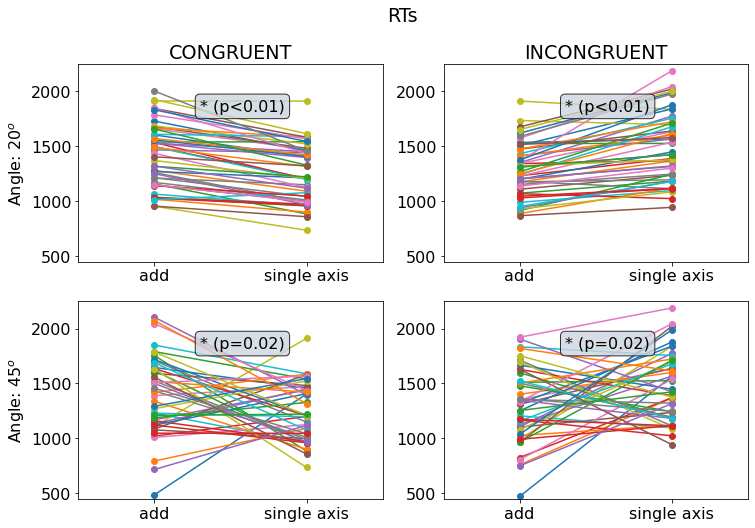

In [93]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plot_paired_value_lines(rt_congr_20, rt_congr_tr_20, p_val = p_con_20, name1 = 'add', name2 = 'single axis', y_lim = [450, 2250], y_label = 'Angle: 20$^o$')
#plot_barplot_two_means(avg_cong_20, ste_cong_20, avg_contr_20, ste_contr_20, p_val = p_con_20, name1 = 'add', name2 = 'single axis', y_label = 'Angle: 20$^o$', bar_col = '#ffda4f')
plt.title('CONGRUENT')
plt.subplot(222)
plot_paired_value_lines(rt_incon_20, rt_incon_tr_20, p_val = p_inc_20, name1 = 'add', name2 = 'single axis', y_lim = [450, 2250])
#plot_barplot_two_means(avg_inc_20, ste_inc_20, avg_inctr_20, ste_inctr_20, p_val = p_inc_20, name1 = 'add', name2 = 'single axis', bar_col = '#dbdcff')
plt.title('INCONGRUENT')
plt.subplot(223)
plot_paired_value_lines(rt_congr_45, rt_congr_tr_45, p_val = p_con_45, name1 = 'add', name2 = 'single axis', y_lim = [450, 2250], y_label = 'Angle: 45$^o$')
#plot_barplot_two_means(avg_cong_45, ste_cong_45, avg_contr_45, ste_contr_45, p_val = p_con_45, name1 = 'add', name2 = 'single axis', y_label = 'Angle: 45$^o$', bar_col = '#ffda4f')
plt.subplot(224)
plot_paired_value_lines(rt_incon_45, rt_incon_tr_45, p_val = p_inc_45, name1 = 'add', name2 = 'single axis',  y_lim = [450, 2250])
#plot_barplot_two_means(avg_inc_45, ste_inc_45, avg_inctr_45, ste_inctr_45, p_val = p_inc_45, name1 = 'add', name2 = 'single axis', bar_col = '#dbdcff')
plt.suptitle('RTs')
plt.savefig('rts.png')
plt.show()

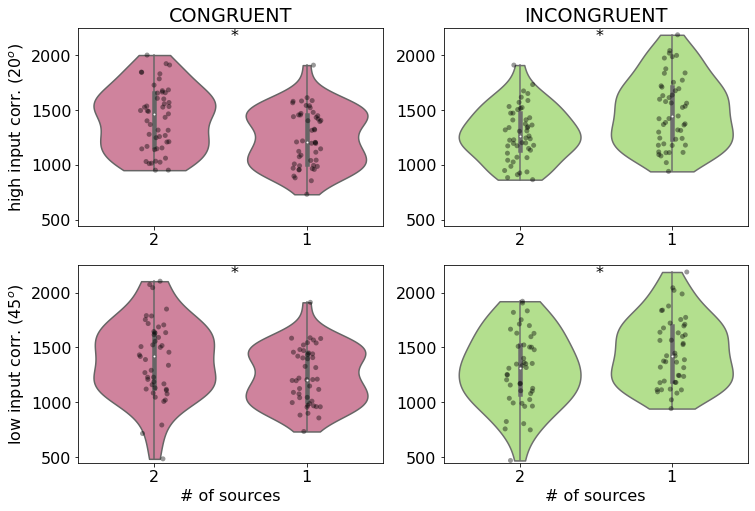

In [96]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plot_two_violin_plots(rt_congr_20, rt_congr_tr_20, p_val = p_con_20,
                      name1 = '2', name2 = '1', y_label = 'high input corr. (20$^o$)',
                      col = '#dc7699', y_lim = [450, 2250], lines = 2, x_label = ' ')
plt.title('CONGRUENT')
plt.subplot(222)
plot_two_violin_plots(rt_incon_20, rt_incon_tr_20, p_val = p_inc_20,
                      name1 = '2', name2 = '1', y_label = ' ',
                      col = '#b2ec81', y_lim = [450, 2250], lines = 2, x_label = ' ')
plt.title('INCONGRUENT')
plt.subplot(223)
plot_two_violin_plots(rt_congr_45, rt_congr_tr_45, p_val = p_con_45,
                      name1 = '2', name2 = '1', y_label = 'low input corr. (45$^o$)',
                      col = '#dc7699', y_lim = [450, 2250], lines = 2, x_label = '# of sources')
plt.subplot(224)
plot_two_violin_plots(rt_incon_45, rt_incon_tr_45, p_val = p_inc_45,
                      name1 = '2', name2 = '1', y_label = ' ',
                      col = '#b2ec81', y_lim = [450, 2250], lines = 2, x_label = '# of sources')
plt.savefig('rts_violin.png')
plt.show()

In [38]:
t_st_con, p_con = st.ttest_ind(rt_congr_20, rt_congr_45)
t_st_inc, p_inc = st.ttest_ind(rt_incon_20, rt_incon_45)
t_st_con_t, p_con_t = st.ttest_ind(rt_congr_tr_20, rt_congr_tr_45)
t_st_inc_t, p_inc_t = st.ttest_ind(rt_incon_tr_20, rt_incon_tr_45)

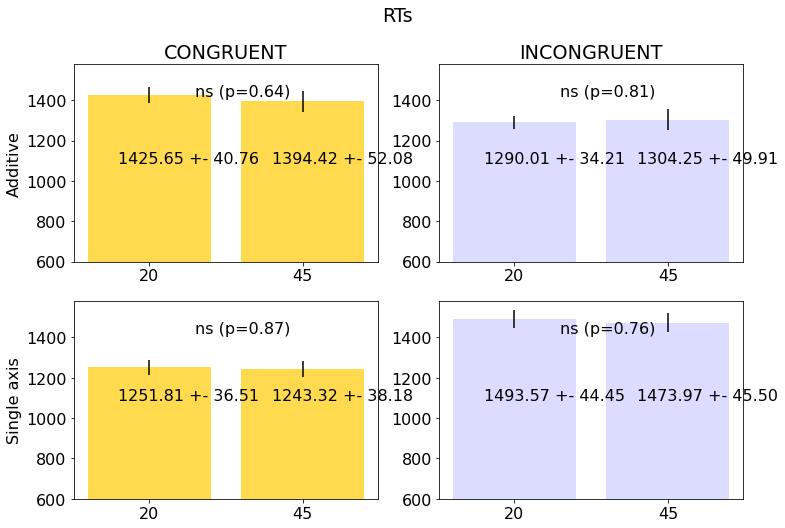

In [39]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plot_barplot_two_means(avg_cong_20, ste_cong_20, avg_cong_45, ste_cong_45, p_val = p_con, name1 = '20', name2 = '45', y_label = 'Additive', bar_col = '#ffda4f', y_lim = (600, 1580))
plt.title('CONGRUENT')
plt.subplot(222)
plot_barplot_two_means(avg_inc_20, ste_inc_20, avg_inc_45, ste_inc_45, p_val = p_inc, name1 = '20', name2 = '45', bar_col = '#dbdcff', y_lim = (600, 1580))
plt.title('INCONGRUENT')
plt.subplot(223)
plot_barplot_two_means(avg_contr_20, ste_contr_20, avg_contr_45, ste_contr_45, p_val = p_con_t, name1 = '20', name2 = '45', y_label = 'Single axis', bar_col = '#ffda4f', y_lim = (600, 1580))
plt.subplot(224)
plot_barplot_two_means(avg_inctr_20, ste_inctr_20, avg_inctr_45, ste_inctr_45, p_val = p_inc_t, name1 = '20', name2 = '45', bar_col = '#dbdcff', y_lim = (600, 1580))
plt.suptitle('RTs')
plt.savefig('rts_angles.png')
plt.show()

In [40]:
df_anova20 = pd.DataFrame(
    {'pid': np.tile(np.tile(np.arange(len(rt_congr_20)), 2), 2),
    'axis': np.concatenate((np.zeros(len(rt_congr_20)), np.ones(len(rt_congr_tr_20)), np.zeros(len(rt_incon_20)), np.ones(len(rt_incon_tr_20)))),
    'congr': np.concatenate((np.zeros(len(rt_congr_20)+len(rt_congr_tr_20)), np.ones(len(rt_incon_20)+len(rt_incon_tr_20)))),
    'rt': np.concatenate((rt_congr_20, rt_congr_tr_20, rt_incon_20, rt_incon_tr_20)) })

In [41]:
print('Angle: 20 (RT)')
avo = pg.rm_anova(data = df_anova20, dv='rt', subject='pid', within=['axis', 'congr'])
avo.round(4)

Angle: 20 (RT)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,axis,1.082404e+04,1,48,1.082404e+04,1.6898,0.1998,0.1998,0.0340,1.0
1,congr,1.379464e+05,1,48,1.379464e+05,27.3094,0.0000,0.0000,0.3626,1.0
2,axis * congr,1.744742e+06,1,48,1.744742e+06,109.9858,0.0000,0.0000,0.6962,1.0


In [42]:
df_anova45 = pd.DataFrame(
    {'pid': np.tile(np.tile(np.arange(len(rt_congr_45)), 2), 2),
    'axis': np.concatenate((np.zeros(len(rt_congr_45)), np.ones(len(rt_congr_tr_45)), np.zeros(len(rt_incon_45)), np.ones(len(rt_incon_tr_45)))),
    'congr': np.concatenate((np.zeros(len(rt_congr_45)+len(rt_congr_tr_45)), np.ones(len(rt_incon_45)+len(rt_incon_tr_45)))),
    'rt': np.concatenate((rt_congr_45, rt_congr_tr_45, rt_incon_45, rt_incon_tr_45)) })
print('Angle: 45 (RT)')
avo = pg.rm_anova(data = df_anova45, dv='rt', subject='pid', within=['axis', 'congr'])
avo.round(4)

Angle: 45 (RT)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,axis,3.902705e+03,1,44,3.902705e+03,0.0201,0.888,0.888,0.0005,1.0
1,congr,2.220324e+05,1,44,2.220324e+05,26.5131,0.000,0.000,0.3760,1.0
2,axis * congr,1.157919e+06,1,44,1.157919e+06,101.7447,0.000,0.000,0.6981,1.0


In [43]:
# do posthoc test on interaction

In [44]:
posthocs = pg.pairwise_ttests(data = df_anova20, dv='rt', subject='pid', within=['axis', 'congr'])
posthocs#pg.print_table(posthocs, tablefmt='simple')

,Contrast,axis,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,axis,-,0,1,True,True,-1.299927,48.0,two-sided,1.998338e-01,0.342,-0.055128
1,congr,-,0,1,True,True,-5.225842,48.0,two-sided,3.720286e-06,4821.301,-0.197270
2,axis * congr,0,0,1,True,True,7.568940,48.0,two-sided,9.927016e-10,1.132e+07,0.505699
3,axis * congr,1,0,1,True,True,-10.476460,48.0,two-sided,5.397948e-14,1.383e+11,-0.833882


In [45]:
posthocs = pg.pairwise_ttests(data = df_anova45, dv='rt', subject='pid', within=['axis', 'congr'])
posthocs

,Contrast,axis,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,axis,-,0,1,True,True,-0.141713,44.0,two-sided,8.879533e-01,0.163,-0.029875
1,congr,-,0,1,True,True,-5.149086,44.0,two-sided,5.883981e-06,3205.093,-0.314529
2,axis * congr,0,0,1,True,True,5.211801,44.0,two-sided,4.776248e-06,3889.788,0.258370
3,axis * congr,1,0,1,True,True,-9.588195,44.0,two-sided,2.404571e-12,3.588e+09,-0.802570


In [46]:
# mixed effect anova: 2 (angles) x 2x2 (RM)

In [47]:
df_anova45.pid = df_anova45.pid + max(df_anova20.pid)+1
df_anova_all = pd.concat((df_anova20, df_anova45))
df_anova_all['angle'] = [20]*df_anova20.shape[0] + [45]*df_anova45.shape[0]

In [48]:
jaspdf = {'pid': list(range(len(rt_congr_20) + len(rt_congr_45))),
 'cong_2':rt_congr_20 + rt_congr_45,
 'cong_1':rt_congr_tr_20 + rt_congr_tr_45,
 'inc_2':rt_incon_20 + rt_incon_45,
 'inc_1':rt_incon_tr_20 + rt_incon_tr_45,
 'angle':len(rt_congr_20)*[20]+len(rt_congr_45)*[45]}
jaspdf = pd.DataFrame(jaspdf)
jaspdf.to_csv('rt_jasp.csv')

In [49]:
df_anova_all.head()

,pid,axis,congr,rt,angle
0,0,0.0,0.0,1603.242604,20
1,1,0.0,0.0,1280.912812,20
2,2,0.0,0.0,1157.279948,20
3,3,0.0,0.0,1534.304844,20
4,4,0.0,0.0,1467.382760,20


In [50]:
#aov = pg.mixed_anova(dv='rt', within=['axis', 'congr'], between='angle', subject='pid', data=df_anova_all)
#aov

## Export single-trial

In [51]:
lists20 = []
for i in range(len(subj_20)):
    dft = subj_20[i]['part2']['trials']
    dft.loc[:, 'subj_idx'] = i
    dft.loc[:, 'angle'] = 20
    dft = dft.reset_index(drop=True)
    dft.correct = dft.correct*1
    dtf = dft.rename(columns={"correct": "response"})
    lists20.append(dtf)

lists45 = []
for i in range(len(subj_45)):
    dft = subj_45[i]['part2']['trials']
    dft.loc[:, 'subj_idx'] = i
    dft.loc[:, 'angle'] = 45
    dft = dft.reset_index(drop=True)
    dft.correct = dft.correct*1
    dtf = dft.rename(columns={"correct": "response"})
    lists45.append(dtf)

In [52]:
df_trials_export = pd.concat(lists20+lists45)
df_trials_export = df_trials_export.reset_index(drop=True)

In [53]:
df_trials_export.to_csv('trials_all.csv')

## Extra age analysis

RT: 20-con, r = -0.05, p = 0.74
RT: 20-inc, r = -0.10, p = 0.48
RT: 45-con, r = -0.11, p = 0.47
RT: 45-inc, r = 0.02, p = 0.87


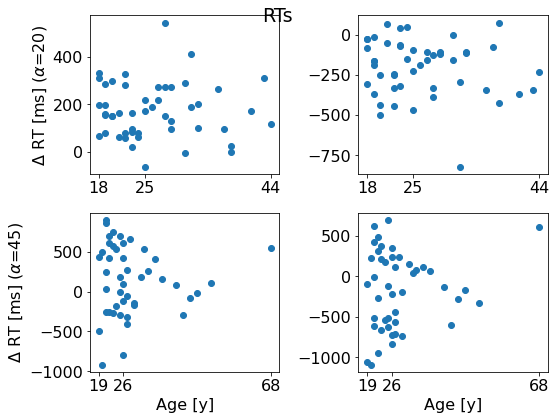

In [54]:
plt.figure(figsize=(8,6))

age = summary_a20.age.to_numpy()
plt.suptitle('RTs')
plt.subplot(221)
val = np.array(rt_congr_20)-np.array(rt_congr_tr_20)
plt.plot(age, val, 'o')
plt.xticks([min(age), np.median(age), max(age)])
plt.ylabel(r'$\Delta$ RT [ms] ($\alpha$=20)')
r,p = st.spearmanr(age, val)
print('RT: 20-con, r = {:.2f}, p = {:.2f}'.format(r,p) )
plt.subplot(222)
val = np.array(rt_incon_20)-np.array(rt_incon_tr_20)
plt.plot(age, val, 'o')
plt.xticks([min(age), np.median(age), max(age)])
r,p = st.spearmanr(age, val)
print('RT: 20-inc, r = {:.2f}, p = {:.2f}'.format(r,p) )

age = summary_a45.age.to_numpy()
plt.subplot(223)
val = np.array(rt_congr_45)-np.array(rt_congr_tr_45)
plt.plot(age, val, 'o')
plt.xticks([min(age), np.median(age), max(age)])
plt.xlabel('Age [y]')
plt.ylabel(r'$\Delta$ RT [ms] ($\alpha$=45)')
r,p = st.spearmanr(age, val)
print('RT: 45-con, r = {:.2f}, p = {:.2f}'.format(r,p) )
plt.subplot(224)
val = np.array(rt_incon_45)-np.array(rt_incon_tr_45)
plt.plot(age, val, 'o')
plt.xticks([min(age), np.median(age), max(age)])
plt.xlabel('Age [y]')
plt.tight_layout()
r,p = st.spearmanr(age, val)
print('RT: 45-inc, r = {:.2f}, p = {:.2f}'.format(r,p) )

ACC: 20-con, r = -0.28, p = 0.05
RT: 20-inc, r = 0.22, p = 0.13
ACC: 45-con, r = -0.05, p = 0.74
ACC: 45-inc, r = -0.23, p = 0.13


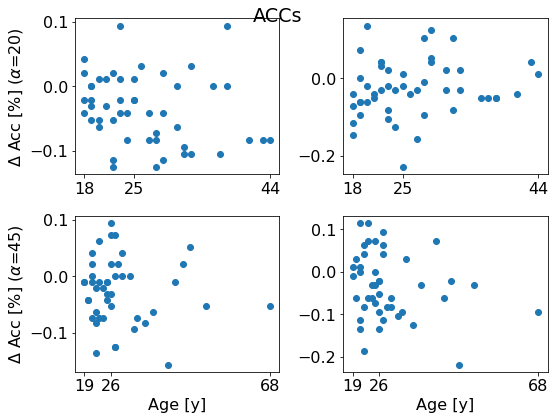

In [55]:
plt.figure(figsize=(8,6))

age = summary_a20.age.to_numpy()
plt.suptitle('ACCs')
plt.subplot(221)
val = np.array(correct_congr_20)-np.array(correct_congr_tr_20)
plt.plot(age, val, 'o')
plt.xticks([min(age), np.median(age), max(age)])
plt.ylabel(r'$\Delta$ Acc [%] ($\alpha$=20)')
r,p = st.spearmanr(age, val)
print('ACC: 20-con, r = {:.2f}, p = {:.2f}'.format(r,p) )
plt.subplot(222)
val = np.array(correct_incon_20)-np.array(correct_incon_tr_20)
plt.plot(age, val, 'o')
plt.xticks([min(age), np.median(age), max(age)])
r,p = st.spearmanr(age, val)
print('RT: 20-inc, r = {:.2f}, p = {:.2f}'.format(r,p) )

age = summary_a45.age.to_numpy()
plt.subplot(223)
val = np.array(correct_congr_45)-np.array(correct_congr_tr_45)
plt.plot(age, val, 'o')
plt.xticks([min(age), np.median(age), max(age)])
plt.xlabel('Age [y]')
plt.ylabel(r'$\Delta$ Acc [%] ($\alpha$=45)')
r,p = st.spearmanr(age, val)
print('ACC: 45-con, r = {:.2f}, p = {:.2f}'.format(r,p) )
plt.subplot(224)
val = np.array(correct_incon_45)-np.array(correct_incon_tr_45)
plt.plot(age, val, 'o')
plt.xticks([min(age), np.median(age), max(age)])
plt.xlabel('Age [y]')
plt.tight_layout()
r,p = st.spearmanr(age, val)
print('ACC: 45-inc, r = {:.2f}, p = {:.2f}'.format(r,p) )